In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler


In [2]:
# Load the dataset
from google.colab import files
import pandas as pd

# Upload the file
uploaded = files.upload()


Saving ENB2012_data.xlsx to ENB2012_data.xlsx


In [3]:


data = pd.read_excel('ENB2012_data.xlsx')
print(data.head())


     X1     X2     X3      X4   X5  X6   X7  X8     Y1     Y2
0  0.98  514.5  294.0  110.25  7.0   2  0.0   0  15.55  21.33
1  0.98  514.5  294.0  110.25  7.0   3  0.0   0  15.55  21.33
2  0.98  514.5  294.0  110.25  7.0   4  0.0   0  15.55  21.33
3  0.98  514.5  294.0  110.25  7.0   5  0.0   0  15.55  21.33
4  0.90  563.5  318.5  122.50  7.0   2  0.0   0  20.84  28.28


In [4]:
X = data[['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8']]
Y_heating = data['Y1']
Y_cooling = data['Y2']

# Feature scaling (standardizing the data)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data into train and test sets
X_train, X_test, Y_train_heating, Y_test_heating = train_test_split(X_scaled, Y_heating, test_size=0.2, random_state=42)
X_train, X_test, Y_train_cooling, Y_test_cooling = train_test_split(X_scaled, Y_cooling, test_size=0.2, random_state=42)


In [5]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

Heating Load MSE - Stacked Model: 1.7500
Heating Load RMSE - Stacked Model: 1.3229


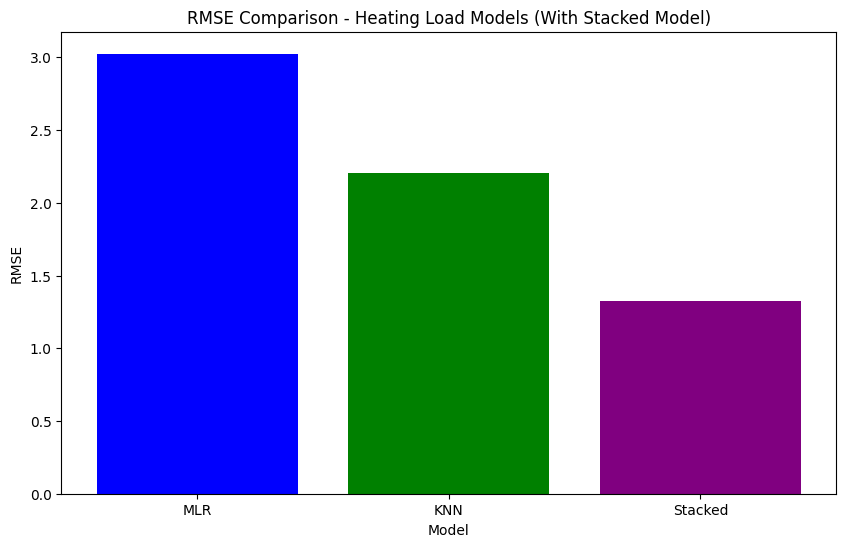

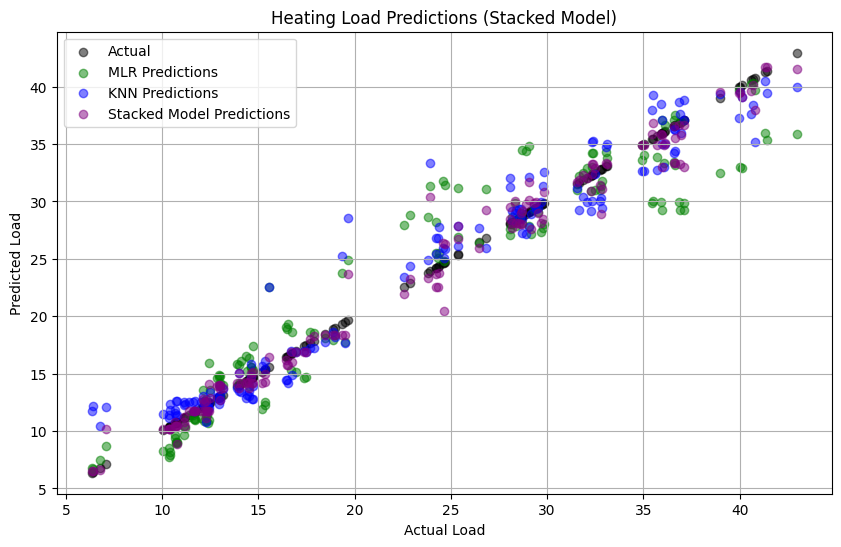

In [6]:

# Define features and target variable (heating load)
X = data[['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8']]
Y_heating = data['Y1']

# Splitting data into training and testing sets
X_train, X_test, Y_train_heating, Y_test_heating = train_test_split(X, Y_heating, test_size=0.2, random_state=42)

# Define a function to create meta-features (predictions from base models)
def create_meta_features(X_train, X_test, Y_train, base_models):
    X_meta_train = np.zeros((X_train.shape[0], len(base_models)))
    X_meta_test = np.zeros((X_test.shape[0], len(base_models)))

    kf = KFold(n_splits=5, shuffle=True, random_state=42)  # Cross-validation

    for i, model in enumerate(base_models):
        # Use cross-validation to get meta-features for the training set
        for train_idx, val_idx in kf.split(X_train):
            model.fit(X_train[train_idx], Y_train[train_idx])
            X_meta_train[val_idx, i] = model.predict(X_train[val_idx])

        # Train the base model on the entire training set and predict for the test set
        model.fit(X_train, Y_train)
        X_meta_test[:, i] = model.predict(X_test)

    return X_meta_train, X_meta_test

# Initialize base models (MLR and KNN)
base_models = [LinearRegression(), KNeighborsRegressor(n_neighbors=5)]

# Create meta-features using base models
X_meta_train, X_meta_test = create_meta_features(X_train.values, X_test.values, Y_train_heating.values, base_models)

# Train a meta-model (e.g., GradientBoostingRegressor)
meta_model = GradientBoostingRegressor()
meta_model.fit(X_meta_train, Y_train_heating)

# Predictions using the meta-model
Y_pred_meta = meta_model.predict(X_meta_test)

# Evaluate the stacked model
mse_meta_heating = mean_squared_error(Y_test_heating, Y_pred_meta)
rmse_meta_heating = np.sqrt(mse_meta_heating)
print(f"Heating Load MSE - Stacked Model: {mse_meta_heating:.4f}")
print(f"Heating Load RMSE - Stacked Model: {rmse_meta_heating:.4f}")

# Compare RMSE with other models
mse_mlr_heating = mean_squared_error(Y_test_heating, LinearRegression().fit(X_train, Y_train_heating).predict(X_test))
mse_knn_heating = mean_squared_error(Y_test_heating, KNeighborsRegressor(n_neighbors=5).fit(X_train, Y_train_heating).predict(X_test))

rmse_mlr_heating = np.sqrt(mse_mlr_heating)
rmse_knn_heating = np.sqrt(mse_knn_heating)

# RMSE comparison
metrics_heating = ['MLR', 'KNN', 'Stacked']
rmse_values_heating = [rmse_mlr_heating, rmse_knn_heating, rmse_meta_heating]

plt.figure(figsize=(10, 6))
plt.bar(metrics_heating, rmse_values_heating, color=['blue', 'green', 'purple'])
plt.xlabel('Model')
plt.ylabel('RMSE')
plt.title('RMSE Comparison - Heating Load Models (With Stacked Model)')
plt.show()

# Function to plot predictions
def plot_predictions(Y_test, Y_pred_mlr, Y_pred_knn, Y_pred_meta, title):
    plt.figure(figsize=(10, 6))
    plt.scatter(Y_test, Y_test, color='black', label='Actual', alpha=0.5)
    plt.scatter(Y_test, Y_pred_mlr, color='green', label='MLR Predictions', alpha=0.5)
    plt.scatter(Y_test, Y_pred_knn, color='blue', label='KNN Predictions', alpha=0.5)
    plt.scatter(Y_test, Y_pred_meta, color='purple', label='Stacked Model Predictions', alpha=0.5)

    plt.title(title)
    plt.xlabel('Actual Load')
    plt.ylabel('Predicted Load')
    plt.legend()
    plt.grid()
    plt.show()

# Plot predictions for the stacked model
plot_predictions(Y_test_heating,
                 LinearRegression().fit(X_train, Y_train_heating).predict(X_test),
                 KNeighborsRegressor(n_neighbors=5).fit(X_train, Y_train_heating).predict(X_test),
                 Y_pred_meta, 'Heating Load Predictions (Stacked Model)')

Stacked Model (Gradient Boosting) - Heating Load:
MSE: 1.7445
RMSE: 1.3208
R²: 0.9833

MLR Model - Heating Load:
MSE: 9.1517
RMSE: 3.0252
R²: 0.9122

KNN Model - Heating Load:
MSE: 4.8547
RMSE: 2.2033
R²: 0.9534


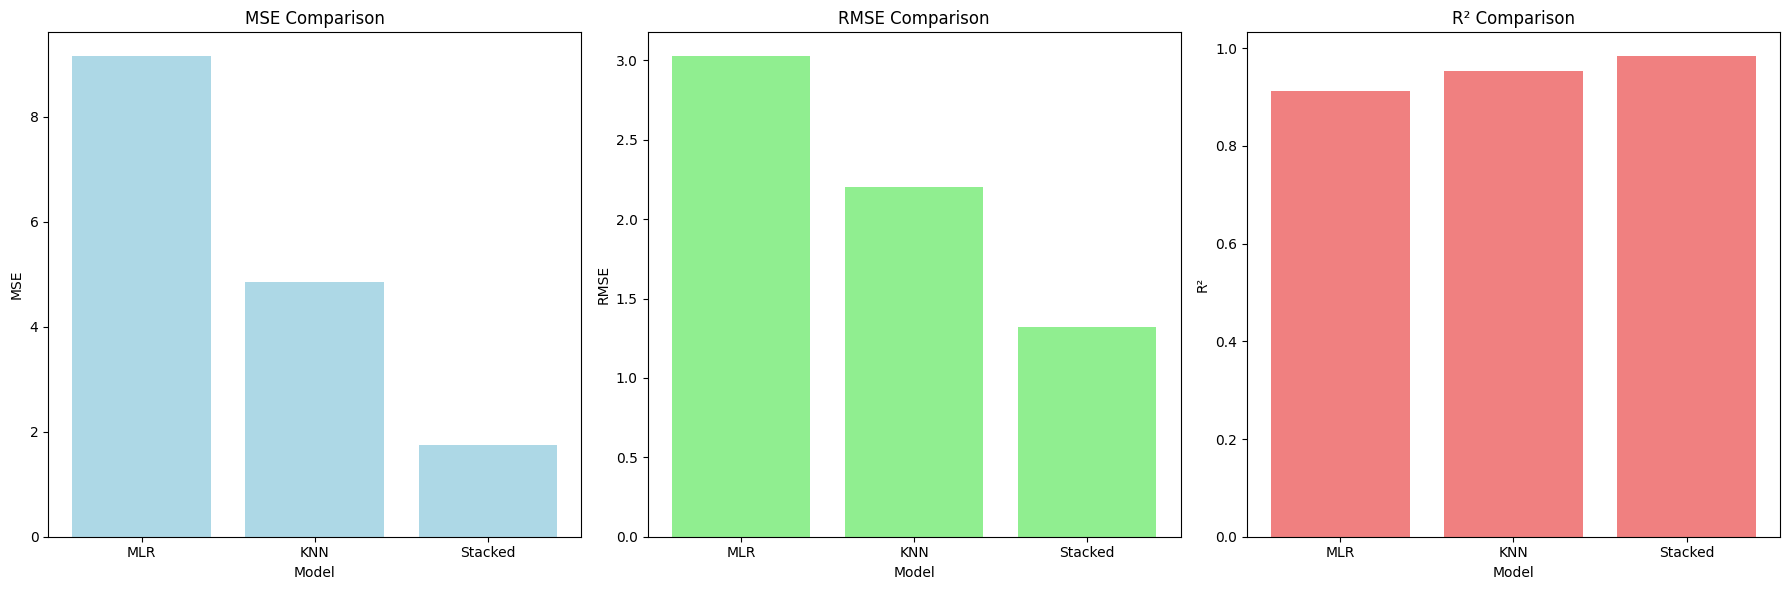

In [9]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor

# Define features and target variable (heating load)
X = data[['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8']]
Y_heating = data['Y1']

# Splitting data into training and testing sets
X_train, X_test, Y_train_heating, Y_test_heating = train_test_split(X, Y_heating, test_size=0.2, random_state=42)

# Define a function to create meta-features (predictions from base models)
def create_meta_features(X_train, X_test, Y_train, base_models):
    X_meta_train = np.zeros((X_train.shape[0], len(base_models)))
    X_meta_test = np.zeros((X_test.shape[0], len(base_models)))

    kf = KFold(n_splits=5, shuffle=True, random_state=42)  # Cross-validation

    for i, model in enumerate(base_models):
        # Use cross-validation to get meta-features for the training set
        for train_idx, val_idx in kf.split(X_train):
            model.fit(X_train[train_idx], Y_train[train_idx])
            X_meta_train[val_idx, i] = model.predict(X_train[val_idx])

        # Train the base model on the entire training set and predict for the test set
        model.fit(X_train, Y_train)
        X_meta_test[:, i] = model.predict(X_test)

    return X_meta_train, X_meta_test

# Initialize base models (MLR and KNN)
base_models = [LinearRegression(), KNeighborsRegressor(n_neighbors=5)]

# Create meta-features using base models
X_meta_train, X_meta_test = create_meta_features(X_train.values, X_test.values, Y_train_heating.values, base_models)

# Train a meta-model (e.g., GradientBoostingRegressor)
meta_model = GradientBoostingRegressor()
meta_model.fit(X_meta_train, Y_train_heating)

# Predictions using the meta-model
Y_pred_meta = meta_model.predict(X_meta_test)

# Evaluate the stacked model
mse_meta_heating = mean_squared_error(Y_test_heating, Y_pred_meta)
rmse_meta_heating = np.sqrt(mse_meta_heating)
r2_meta_heating = r2_score(Y_test_heating, Y_pred_meta)

print(f"Stacked Model (Gradient Boosting) - Heating Load:")
print(f"MSE: {mse_meta_heating:.4f}")
print(f"RMSE: {rmse_meta_heating:.4f}")
print(f"R²: {r2_meta_heating:.4f}")
print()

# Generate predictions for MLR and KNN to avoid redundant training
Y_pred_mlr_heating = LinearRegression().fit(X_train, Y_train_heating).predict(X_test)
Y_pred_knn_heating = KNeighborsRegressor(n_neighbors=5).fit(X_train, Y_train_heating).predict(X_test)

# Calculate RMSE and R² for comparison
mse_mlr_heating = mean_squared_error(Y_test_heating, Y_pred_mlr_heating)
rmse_mlr_heating = np.sqrt(mse_mlr_heating)
r2_mlr_heating = r2_score(Y_test_heating, Y_pred_mlr_heating)

mse_knn_heating = mean_squared_error(Y_test_heating, Y_pred_knn_heating)
rmse_knn_heating = np.sqrt(mse_knn_heating)
r2_knn_heating = r2_score(Y_test_heating, Y_pred_knn_heating)

# Print MSE, RMSE, and R² values for each model
print(f"MLR Model - Heating Load:")
print(f"MSE: {mse_mlr_heating:.4f}")
print(f"RMSE: {rmse_mlr_heating:.4f}")
print(f"R²: {r2_mlr_heating:.4f}")
print()

print(f"KNN Model - Heating Load:")
print(f"MSE: {mse_knn_heating:.4f}")
print(f"RMSE: {rmse_knn_heating:.4f}")
print(f"R²: {r2_knn_heating:.4f}")
# Prepare data for plotting
models = ['MLR', 'KNN', 'Stacked']
mse_values = [mse_mlr_heating, mse_knn_heating, mse_meta_heating]
rmse_values = [rmse_mlr_heating, rmse_knn_heating, rmse_meta_heating]
r2_values = [r2_mlr_heating, r2_knn_heating, r2_meta_heating]

# Plot MSE, RMSE, and R² values for each model
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# MSE plot
axs[0].bar(models, mse_values, color='lightblue')
axs[0].set_title('MSE Comparison')
axs[0].set_xlabel('Model')
axs[0].set_ylabel('MSE')

# RMSE plot
axs[1].bar(models, rmse_values, color='lightgreen')
axs[1].set_title('RMSE Comparison')
axs[1].set_xlabel('Model')
axs[1].set_ylabel('RMSE')

# R² plot
axs[2].bar(models, r2_values, color='lightcoral')
axs[2].set_title('R² Comparison')
axs[2].set_xlabel('Model')
axs[2].set_ylabel('R²')

plt.tight_layout()
plt.show()


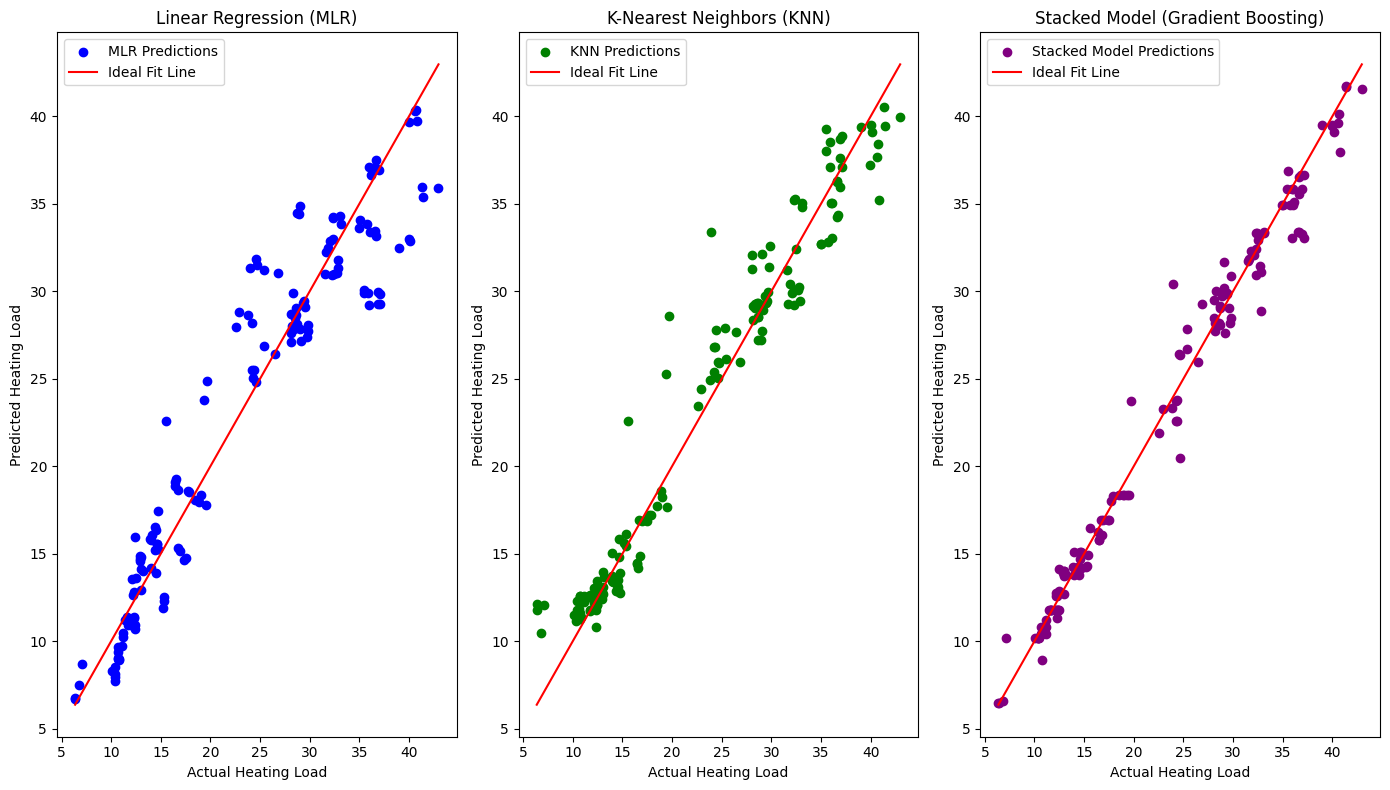

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, KFold

X_train, X_test, Y_train_heating, Y_test_heating = train_test_split(X, Y_heating, test_size=0.2, random_state=42)

# Create base model predictions for MLR and KNN
Y_pred_mlr_heating = LinearRegression().fit(X_train, Y_train_heating).predict(X_test)
Y_pred_knn_heating = KNeighborsRegressor(n_neighbors=5).fit(X_train, Y_train_heating).predict(X_test)

# Create meta-features for stacking
base_models = [LinearRegression(), KNeighborsRegressor(n_neighbors=5)]
X_meta_train, X_meta_test = create_meta_features(X_train.values, X_test.values, Y_train_heating.values, base_models)

# Train meta-model (Gradient Boosting)
meta_model = GradientBoostingRegressor()
meta_model.fit(X_meta_train, Y_train_heating)
Y_pred_meta = meta_model.predict(X_meta_test)

# Plot regression lines
def plot_regression_lines(Y_test, Y_pred_mlr, Y_pred_knn, Y_pred_meta):
    plt.figure(figsize=(14, 8))

    # Plot Linear Regression
    plt.subplot(1, 3, 1)
    plt.scatter(Y_test, Y_pred_mlr, color='blue', label='MLR Predictions')
    plt.plot([min(Y_test), max(Y_test)], [min(Y_test), max(Y_test)], color='red', label='Ideal Fit Line')
    plt.xlabel('Actual Heating Load')
    plt.ylabel('Predicted Heating Load')
    plt.title('Linear Regression (MLR)')
    plt.legend()

    # Plot K-Nearest Neighbors
    plt.subplot(1, 3, 2)
    plt.scatter(Y_test, Y_pred_knn, color='green', label='KNN Predictions')
    plt.plot([min(Y_test), max(Y_test)], [min(Y_test), max(Y_test)], color='red', label='Ideal Fit Line')
    plt.xlabel('Actual Heating Load')
    plt.ylabel('Predicted Heating Load')
    plt.title('K-Nearest Neighbors (KNN)')
    plt.legend()

    # Plot Stacked Model
    plt.subplot(1, 3, 3)
    plt.scatter(Y_test, Y_pred_meta, color='purple', label='Stacked Model Predictions')
    plt.plot([min(Y_test), max(Y_test)], [min(Y_test), max(Y_test)], color='red', label='Ideal Fit Line')
    plt.xlabel('Actual Heating Load')
    plt.ylabel('Predicted Heating Load')
    plt.title('Stacked Model (Gradient Boosting)')
    plt.legend()

    # Show the plots
    plt.tight_layout()
    plt.show()

# Call the plot function with predictions
plot_regression_lines(Y_test_heating, Y_pred_mlr_heating, Y_pred_knn_heating, Y_pred_meta)


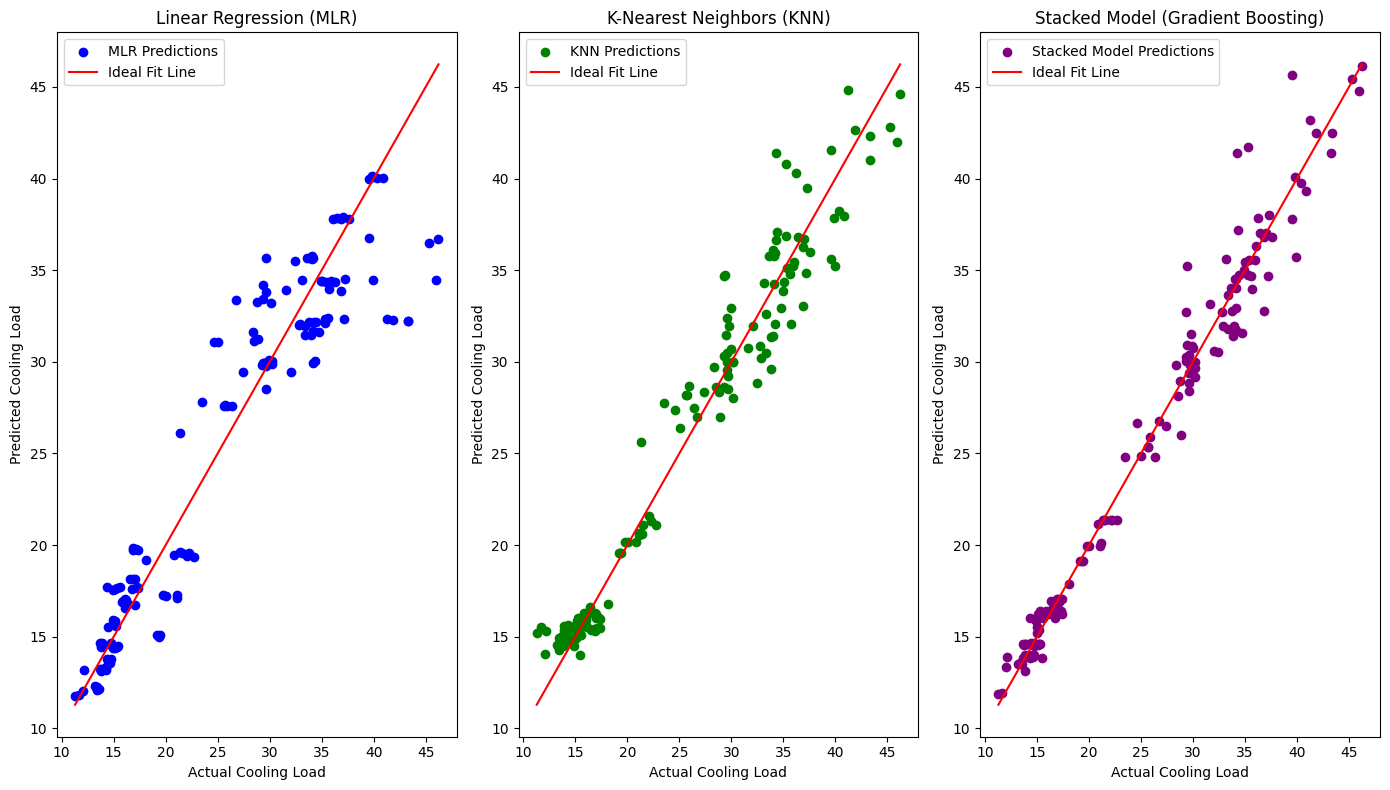

In [ ]:
# Define features and target variable (cooling load)
Y_cooling = data['Y2']  # Assuming 'Y2' is the column for cooling load

# Splitting data into training and testing sets for cooling load
X_train_cooling, X_test_cooling, Y_train_cooling, Y_test_cooling = train_test_split(X, Y_cooling, test_size=0.2, random_state=42)

# Create base model predictions for MLR and KNN for cooling load
Y_pred_mlr_cooling = LinearRegression().fit(X_train_cooling, Y_train_cooling).predict(X_test_cooling)
Y_pred_knn_cooling = KNeighborsRegressor(n_neighbors=5).fit(X_train_cooling, Y_train_cooling).predict(X_test_cooling)

# Create meta-features for stacking for cooling load
X_meta_train_cooling, X_meta_test_cooling = create_meta_features(X_train_cooling.values, X_test_cooling.values, Y_train_cooling.values, base_models)

# Train meta-model (Gradient Boosting) for cooling load
meta_model_cooling = GradientBoostingRegressor()
meta_model_cooling.fit(X_meta_train_cooling, Y_train_cooling)
Y_pred_meta_cooling = meta_model_cooling.predict(X_meta_test_cooling)

# Plot regression lines for cooling load
def plot_regression_lines_cooling(Y_test, Y_pred_mlr, Y_pred_knn, Y_pred_meta):
    plt.figure(figsize=(14, 8))

    # Plot Linear Regression
    plt.subplot(1, 3, 1)
    plt.scatter(Y_test, Y_pred_mlr, color='blue', label='MLR Predictions')
    plt.plot([min(Y_test), max(Y_test)], [min(Y_test), max(Y_test)], color='red', label='Ideal Fit Line')
    plt.xlabel('Actual Cooling Load')
    plt.ylabel('Predicted Cooling Load')
    plt.title('Linear Regression (MLR)')
    plt.legend()

    # Plot K-Nearest Neighbors
    plt.subplot(1, 3, 2)
    plt.scatter(Y_test, Y_pred_knn, color='green', label='KNN Predictions')
    plt.plot([min(Y_test), max(Y_test)], [min(Y_test), max(Y_test)], color='red', label='Ideal Fit Line')
    plt.xlabel('Actual Cooling Load')
    plt.ylabel('Predicted Cooling Load')
    plt.title('K-Nearest Neighbors (KNN)')
    plt.legend()

    # Plot Stacked Model
    plt.subplot(1, 3, 3)
    plt.scatter(Y_test, Y_pred_meta, color='purple', label='Stacked Model Predictions')
    plt.plot([min(Y_test), max(Y_test)], [min(Y_test), max(Y_test)], color='red', label='Ideal Fit Line')
    plt.xlabel('Actual Cooling Load')
    plt.ylabel('Predicted Cooling Load')
    plt.title('Stacked Model (Gradient Boosting)')
    plt.legend()

    # Show the plots
    plt.tight_layout()
    plt.show()

# Call the plot function with predictions for cooling load
plot_regression_lines_cooling(Y_test_cooling, Y_pred_mlr_cooling, Y_pred_knn_cooling, Y_pred_meta_cooling)


Cooling Load MSE - Stacked Model: 2.3248
Cooling Load RMSE - Stacked Model: 1.5247
Cooling Load R² - Stacked Model: 0.9749
Cooling Load RMSE - MLR: 3.1458
Cooling Load RMSE - KNN: 1.9950
Cooling Load R² - MLR: 0.8932
Cooling Load R² - KNN: 0.9570
Cooling Load R² - Stacked Model: 0.9749


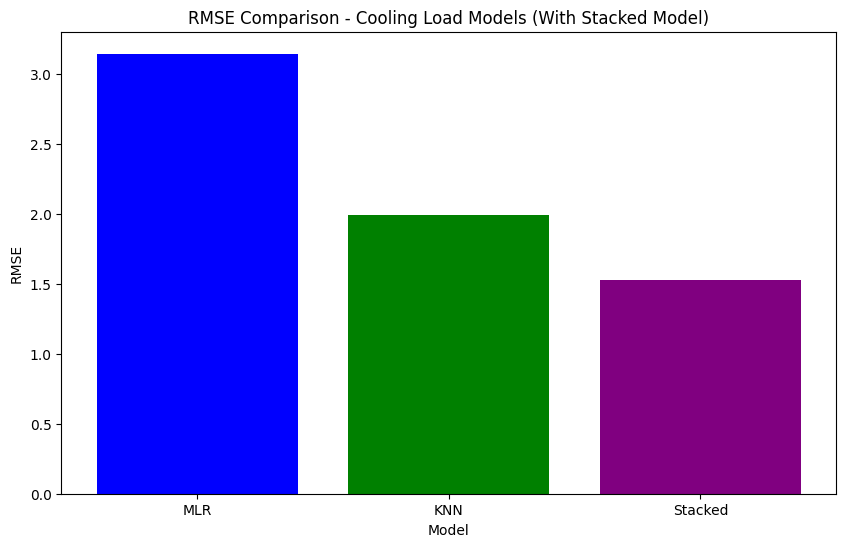

In [ ]:
# Evaluate the stacked model for cooling load
mse_meta_cooling = mean_squared_error(Y_test_cooling, Y_pred_meta_cooling)
rmse_meta_cooling = np.sqrt(mse_meta_cooling)
r2_meta_cooling = r2_score(Y_test_cooling, Y_pred_meta_cooling)

# Print MSE, RMSE, R² for stacked model
print(f"Cooling Load MSE - Stacked Model: {mse_meta_cooling:.4f}")
print(f"Cooling Load RMSE - Stacked Model: {rmse_meta_cooling:.4f}")
print(f"Cooling Load R² - Stacked Model: {r2_meta_cooling:.4f}")

# Generate predictions for MLR and KNN to avoid redundant training
Y_pred_mlr_cooling = LinearRegression().fit(X_train_cooling, Y_train_cooling).predict(X_test_cooling)
Y_pred_knn_cooling = KNeighborsRegressor(n_neighbors=5).fit(X_train_cooling, Y_train_cooling).predict(X_test_cooling)

# Calculate RMSE for MLR and KNN for cooling load
rmse_mlr_cooling = np.sqrt(mean_squared_error(Y_test_cooling, Y_pred_mlr_cooling))
rmse_knn_cooling = np.sqrt(mean_squared_error(Y_test_cooling, Y_pred_knn_cooling))

# Calculate R² for MLR and KNN
r2_mlr_cooling = r2_score(Y_test_cooling, Y_pred_mlr_cooling)
r2_knn_cooling = r2_score(Y_test_cooling, Y_pred_knn_cooling)

# RMSE comparison for cooling load
metrics_cooling = ['MLR', 'KNN', 'Stacked']
rmse_values_cooling = [rmse_mlr_cooling, rmse_knn_cooling, rmse_meta_cooling]

# Print RMSE and R² comparison
print(f"Cooling Load RMSE - MLR: {rmse_mlr_cooling:.4f}")
print(f"Cooling Load RMSE - KNN: {rmse_knn_cooling:.4f}")
print(f"Cooling Load R² - MLR: {r2_mlr_cooling:.4f}")
print(f"Cooling Load R² - KNN: {r2_knn_cooling:.4f}")
print(f"Cooling Load R² - Stacked Model: {r2_meta_cooling:.4f}")

# Plot RMSE comparison for cooling load models
plt.figure(figsize=(10, 6))
plt.bar(metrics_cooling, rmse_values_cooling, color=['blue', 'green', 'purple'])
plt.xlabel('Model')
plt.ylabel('RMSE')
plt.title('RMSE Comparison - Cooling Load Models (With Stacked Model)')
plt.show()
